# Interpretability of a Convolutional Neural Network

Notebook created by [Daniel Fojo](https://www.linkedin.com/in/daniel-fojo/) and [Xavier Giro-i-Nieto](https://imatge.upc.edu/web/people/xavier-giro) for the [Postgraduate course in artificial intelligence with deep learning](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) ([UPC School](https://www.talent.upc.edu/ing/), 2019). Updated by [Albert Mosella-Montoro](https://www.albertmosellamontoro.com/) in 2020 and for [Paula G. Duran](https://www.linkedin.com/in/paulagd-1995/) in 2022.

Minor contributions by [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/) and [Pol Caselles](https://www.linkedin.com/in/pcaselles/) during 2022.

Based on previous versions by [Amaia Salvador](https://www.linkedin.com/in/amaiasalvador/) ([Persontyle](https://github.com/telecombcn-dl/2017-persontyle), 2017) and [Daniel Fojo](https://www.linkedin.com/in/daniel-fojo/) ([Barcelona Technology School](https://barcelonatechnologyschool.com/), 2019).

In this notebook we will first train a simple model on [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset and then we will perform some visualizations to understand it.

In [1]:
import copy
import time
import itertools

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.ndimage.interpolation import zoom
from scipy.ndimage.filters import gaussian_filter
import copy

from skimage import io
import cv2
import skimage.transform
import os

<ipython-input-1-307bb78584ff>:19: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom
<ipython-input-1-307bb78584ff>:20: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
# Let's define some hyper-parameters
hparams = {
    'sz':56,                    # size of the original noise image
    'upscaling_steps':12,       # how many upscaling are going to be done
    'upscaling_factor': 1.2,    # scale factor applied in each step
    'lr':0.001,                 # learning rate
    'opt_steps': 20,            # number of iterations on each up_scaling step
    'blur': 5,                  # parameter applied to smooth the image after an upscaling step
    'layer': 40,
    'filter': 265,
    'epochs': 5
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Load data

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:04<00:00, 40846212.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Load model


**Exercise 1**: Complete the forward method of the model

In [4]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv_layers = nn.Sequential(

            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),
        )

        self.mlp = nn.Sequential(
            nn.Linear(8 * 8 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(-1),
        )

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:
        # Apply convolutional layers
        x = self.conv_layers(x)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Apply MLP layers
        x = self.mlp(x)

        return x

model = Net()
model.to(device)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.5, inplace=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): LogSoftmax(dim=-1)
  )
)

## Train the model

In [5]:
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters(), lr=hparams['lr'])

In [6]:
t = time.time()
model.train()
for epoch in range(hparams['epochs']):  # loop over the dataset multiple times

    for i, (inputs, labels) in enumerate(trainloader):
        # get the inputs to gpu; data is a list of [inputs, labels]
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # print statistics
        if i % 300 == 299:    # print every 300 mini-batches
            print(f"Epoch {epoch+1}/{hparams['epochs']} [{i+1}/{len(trainloader)}] loss: {loss.item():.2f}")

print('Finished Training')
print(f"Time: {(time.time() - t):.1f}s")

Epoch 1/5 [300/1563] loss: 1.68
Epoch 1/5 [600/1563] loss: 1.61
Epoch 1/5 [900/1563] loss: 1.08
Epoch 1/5 [1200/1563] loss: 1.26
Epoch 1/5 [1500/1563] loss: 1.37
Epoch 2/5 [300/1563] loss: 1.25
Epoch 2/5 [600/1563] loss: 1.18
Epoch 2/5 [900/1563] loss: 1.03
Epoch 2/5 [1200/1563] loss: 1.17
Epoch 2/5 [1500/1563] loss: 0.73
Epoch 3/5 [300/1563] loss: 1.24
Epoch 3/5 [600/1563] loss: 0.69
Epoch 3/5 [900/1563] loss: 1.16
Epoch 3/5 [1200/1563] loss: 0.87
Epoch 3/5 [1500/1563] loss: 1.07
Epoch 4/5 [300/1563] loss: 1.26
Epoch 4/5 [600/1563] loss: 0.87
Epoch 4/5 [900/1563] loss: 1.11
Epoch 4/5 [1200/1563] loss: 0.76
Epoch 4/5 [1500/1563] loss: 0.96
Epoch 5/5 [300/1563] loss: 0.61
Epoch 5/5 [600/1563] loss: 1.00
Epoch 5/5 [900/1563] loss: 0.70
Epoch 5/5 [1200/1563] loss: 0.76
Epoch 5/5 [1500/1563] loss: 0.67
Finished Training
Time: 100.1s


## Understanding the model

We will disable the gradient computation for the rest of the session as we will not need to train anymore the model. To perform inference (evaluation) we do not need this option since we will not be doing backpropagation and so we do not need the model to perform variable's gradient.

In [7]:
# Disable gradients computation
_ = torch.set_grad_enabled(False)

Now we perform inference and we get the model's accuracy:

In [8]:
correct = 0
total = 0
model.eval()
for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {correct / total*100:.1f}%")

Accuracy of the network on the 10000 test images: 74.1%


**Exercise 2:**

Now we get the weights from the first layer and we print their shape. Is this the shape you expected? What does each number stand for?

In [9]:
# get the weights from the first layer to cpu
weights = model.conv_layers[0].weight.cpu().detach() # Detach, since we do not need the gradients
weights.shape

torch.Size([32, 3, 3, 3])

---


Now we will create a function to display the convolution kernels as if they were image. This can give us insight to know what patterns activate each filter.

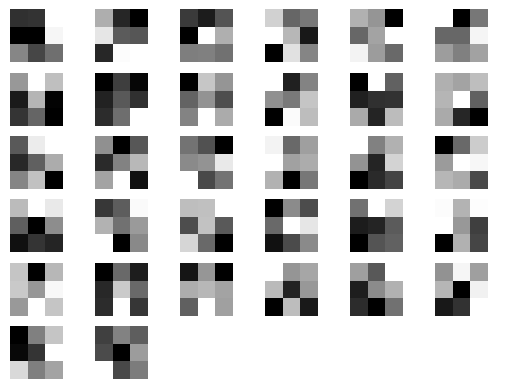

In [11]:
def display_filters(weights: torch.Tensor) -> None:
    N = int(np.ceil(np.sqrt(weights.shape[0])))
    f, axarr = plt.subplots(N, N)

    p = 0
    for i in range(N):
        for j in range(N):
            # empty plot white when out of kernels to display
            if p >= weights.shape[0]:
                krnl = torch.ones((weights.shape[2], weights.shape[3], 3))
            else:
                if weights.shape[1] == 1:
                    krnl = weights[p, :, :, :].permute(1, 2, 0)
                    axarr[i, j].imshow(krnl)
                else:
                    # We just display the first channel of each filter
                    krnl = weights[p,0,:,:]
                    axarr[i, j].imshow(krnl, cmap='gray')
            axarr[i, j].axis('off')
            p += 1
    plt.show()

display_filters(weights)

Do these visualizations help you understand what the model learned? If not, later you can try to visualize the activations when these filters are convolved with the image. For now, let's move on to other visualization methods, but you can come back to this later.

**Exercise 3:** Visualize filters in the second convolutional layer.

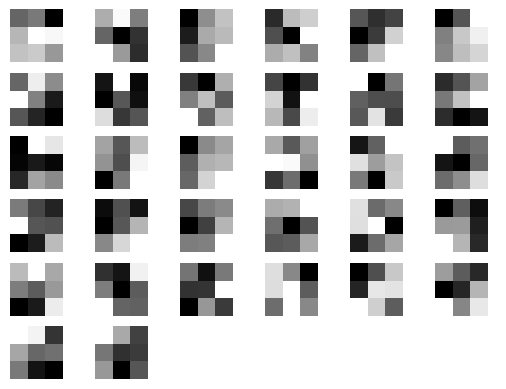

In [12]:
weights = model.conv_layers[2].weight.cpu().detach()
display_filters(weights)


## Activations

We can also use the model's activations fit into our data samples in order to understand what the model learnt.




**Exercise 4:**

We want to create a model that works as a feature extractor. For that, we need to pick just those layers that are useful. Please, complete the Feature Extractor which should output the results from the first Linear layer (before the corresponding activation function).  

- *Hint nº1*: You can call the layers of the original model by doing `self.model.conv_layers(...)`.  
- *Hint nº2*: You can get specific layers from a Sequential module by indexing (consider it a list): `self.model.mlp[...](...)`.

In [14]:
class Extractor(nn.Module):
    def __init__(self,
                 model: torch.nn.Module) -> None:
        super().__init__()
        self.model = model

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:
        # TODO: Give the output of the first Linear layer.
        x = self.model.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.model.mlp[0](x)
        return x

extractor = Extractor(model).to(device).eval()

Once we have our extractor, we can load the data and forward it through the network to get the activations:

In [15]:
feats = []
for data in testloader:
    inputs, _ = data[0].to(device), data[1].to(device)
    feats.append(extractor(inputs).cpu().detach().numpy())

feats = np.concatenate(feats)
feats.shape

(10000, 128)

Once we have extracted activations for all samples in our test set, we will use different visualization tools to understand what the model learned.

## Visualization

### Finding per unit top K samples

Let's now find the K images with highest activation for each neuron in the layer, using the original extracted activations:

In [16]:
testimages = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

K = 10
idxs_top10 = np.argsort(feats, axis=0)[::-1][0:K, :]
picked_samples = np.zeros((K, 128, 32, 32, 3), dtype=float)
for i in range(idxs_top10.shape[0]):
    for j in range(idxs_top10.shape[1]):
        picked_samples[i, j, :, :, :] = np.asarray(testimages[idxs_top10[i, j]][0])/255
picked_samples.shape
# The shape of the tensor corresponds to:
# (n_images,n_units,nb_rows,nb_cols,nb_channels)

Files already downloaded and verified


(10, 128, 32, 32, 3)

```picked_samples``` now contains the 10 images with highest activation for each neuron. Let's visualize these images for some neurons:

**Exercise 5:**

The following array defines which units are selected to display their top K images. Try different units to display their top K images. Do all units respond to distinguishable concepts? Are there units that respond to similar things?

In [20]:
units = [1, 5, 11, 22, 26, 13]

In [21]:
nunits = len(units)
ims = picked_samples[:, units, :, :].squeeze()

def vis_topk(ims: np.ndarray,
             units: list) -> None:
    f, axarr = plt.subplots(ims.shape[0],ims.shape[1],figsize=(10,10))

    for i in range(ims.shape[0]):
        for j in range(ims.shape[1]):

            axarr[i,j].imshow(ims[i,j,:,:,:])
            axarr[i,j].axis('off')
            axarr[0,j].set_title('unit '+ str(units[j]))

(10, 6, 32, 32, 3)

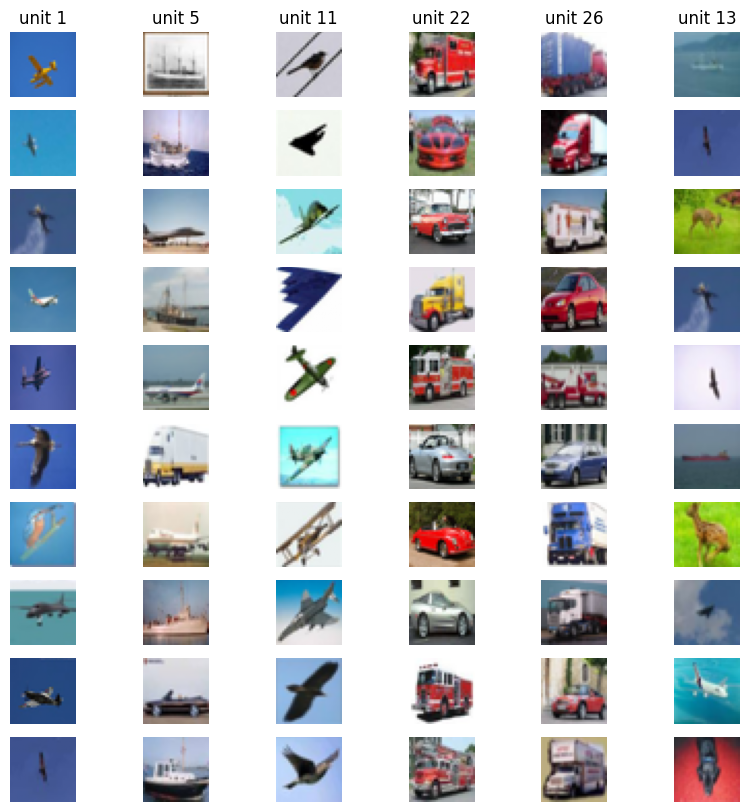

In [22]:
vis_topk(ims, units)
ims.shape
# The shape of the tensor corresponds to:
#(n_ims,n_units_picked,nb_rows,nb_cols,nb_channels)

Did you find any units with semantic meaning? You can try for different units and see what images they like the most.

### Occlusion experiment

Now, can we find what image parts contribute to the activation the most? Let's create a NxN occluder and slide it through each image with a stride of 2, and feed each occluded image through the network. Then, we can obtain the difference between the activations between the original image and the occluded ones, and create a difference map that we can use as a mask on top of the image.

In [23]:
def occ_images(ims: np.ndarray,
               occ: tuple=(11, 11),
               stride: int=4) -> np.ndarray:

    # Reshape to put top images for all units stacked together
    ims = np.rollaxis(ims, 1, 0)
    ims = np.reshape(ims, (ims.shape[0]*ims.shape[1], ims.shape[2], ims.shape[3], ims.shape[4]))
    ims_acc = ims

    # slide
    npos = 1
    st = int(np.floor(occ[0]/2))

    # slide occluder, set pixels to 0 and stack to matrix
    for i in range(st, ims.shape[1], stride):
        for j in range(st, ims.shape[2], stride):
            ims_occ = copy.deepcopy(ims)
            ims_occ[:, i-st:i+occ[0]-st, j-st:j+occ[1]-st, :] = 0
            ims_acc = np.vstack((ims_acc, ims_occ))
            npos += 1

    return ims_acc

In [24]:
ims_acc = occ_images(ims)
print(ims_acc.shape)

(3000, 32, 32, 3)


Let's visualize some of the images with the occluded region in different positions:

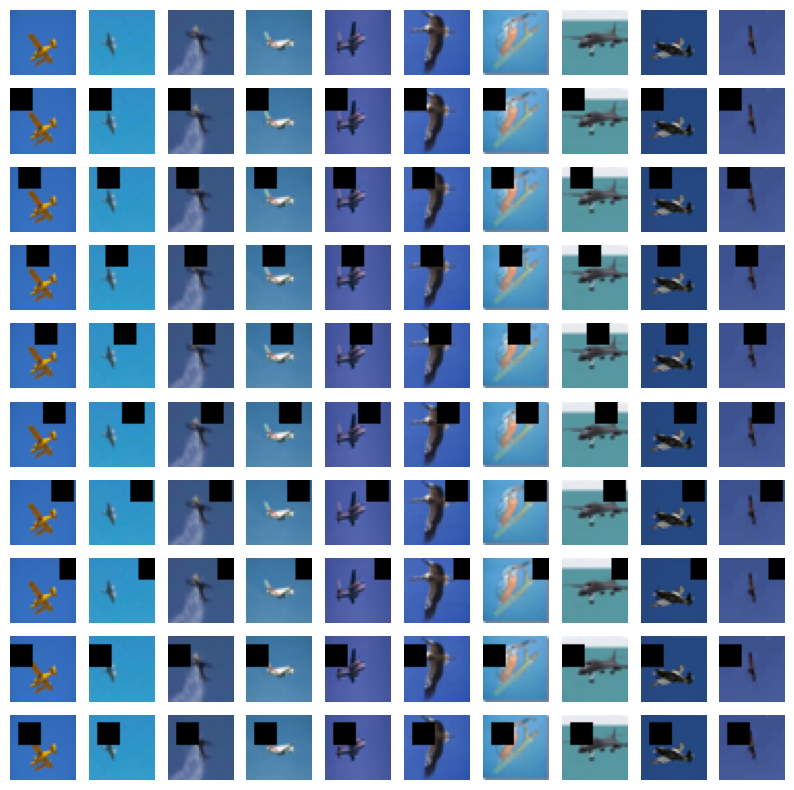

In [25]:
f, axarr = plt.subplots(10, 10, figsize=(10, 10))
ims_acc_r = ims_acc.reshape(ims_acc.shape[0]//(ims.shape[0]*ims.shape[1]),
                                ims.shape[1], ims.shape[0],
                                ims_acc.shape[1], ims_acc.shape[2], ims_acc.shape[3])
for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(ims_acc_r[i,0,j,:,:,:])
        axarr[i,j].axis('off')
plt.show()

We should pick an occluder that is large enough to cover significant parts of objects. 11x11 is the default one, but you can experiment with other sizes and see their effect.

```ims_occ``` contains all images with the occluder set at different positions. Let's run these through our extractor:

In [26]:
ims_acc_tensor = torch.tensor(ims_acc, dtype=torch.float).permute(0, 3, 1, 2).contiguous().to(device)
ims_acc_tensor = (ims_acc_tensor-0.5)/0.5  # Normalize
output = extractor(ims_acc_tensor)
feats_occ = output.cpu().detach().numpy()
feats_occ.shape

(3000, 128)

Now that we have the features, we can compute the difference between the original activation and the activation for each of the occluded images:

In [27]:
feats_r = np.reshape(feats_occ,(feats_occ.shape[0] // (ims.shape[0] * ims.shape[1]),
                                ims.shape[1], ims.shape[0], feats_occ.shape[1]))

distances = feats_r[0] - feats_r[1:] # original activation minus all the occluded ones
distances = np.rollaxis(distances, 0, 4)

Reshaping the distance array into a 2D map will give a mask that we can display on top of the images:

In [28]:
s = int(np.sqrt(distances.shape[3]))

heatmaps = np.zeros((distances.shape[0],distances.shape[1],distances.shape[3]))
for i in range(len(units)):
    heatmaps[i] = distances[i,:,units[i],:]
heatmaps.shape

(6, 10, 49)

Let's write a function to display the masks on top of the images:

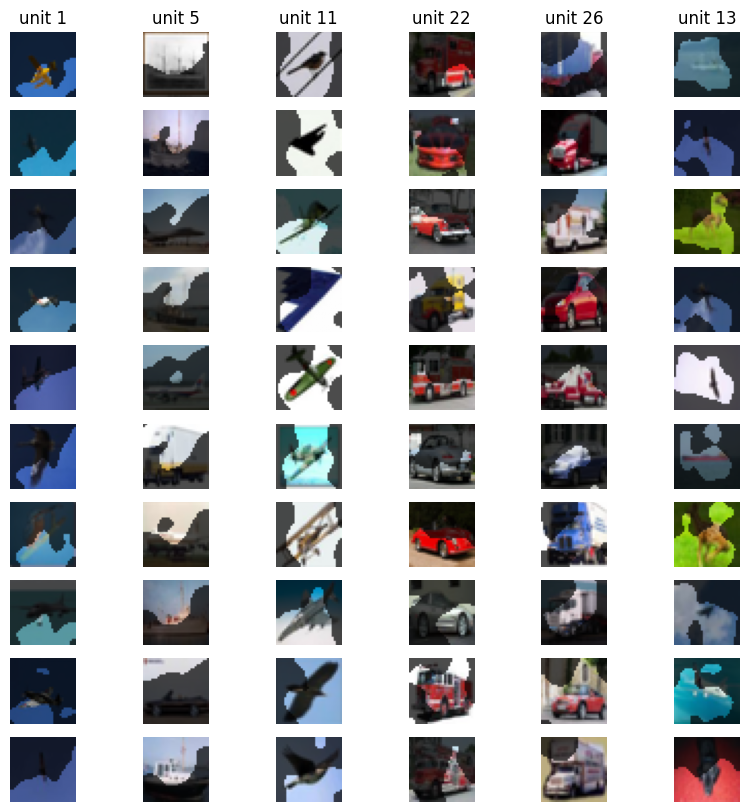

In [29]:
def vis_occ(ims: np.ndarray,
            heatmaps: np.ndarray,
            units: list,
            th: float=0.5,
            sig: int=2) -> None:

    ims = np.rollaxis(ims,1,0)

    s = int(np.sqrt(heatmaps.shape[2]))
    heatmaps = np.reshape(heatmaps,(heatmaps.shape[0],heatmaps.shape[1],s,s))

    f, axarr = plt.subplots(ims.shape[1],ims.shape[0],figsize=(10,10))

    for i in range(ims.shape[0]):
        for j in range(ims.shape[1]):

            im = copy.deepcopy(ims[i,j,:,:,:])
            mask = copy.deepcopy(heatmaps[i,j,:,:])
            if not mask.max() == mask.min():
                # Normalize mask
                mask = (mask - np.min(mask))/(np.max(mask)-np.min(mask))
                # Resize to image size
                mask = zoom(mask,float(im.shape[0])/heatmaps.shape[-1],order=1)
                # Apply gaussian to smooth output
                mask = gaussian_filter(mask,sigma=sig)
                # threshold to obtain mask out of heatmap
                mask[mask>=th] = 1
                mask[mask<th] = 0.3
            else:
                # No heatmap
                mask = zoom(mask,float(im.shape[0])/heatmaps.shape[-1],order=1)
                mask = np.ones_like(mask)*0.3

            # Mask all image channels
            for c in range(3):
                im[:,:,c] = im[:,:,c]*mask

            axarr[j,i].imshow(im)
            axarr[j,i].axis('off')
            axarr[0,i].set_title('unit '+ str(units[i]))

vis_occ(ims, heatmaps, units, th=0.5)

**Exercise 6**:

The obtained masks are of course not perfect, but we get to see what parts of the image are most relevant for each unit in the layer. Are these masks what you expected? Do the picked neurons maximally respond to what you have previously guessed? If you see some fully greyed out images, do they correspond to neurons without semantical meaning?

### Additional: t-SNE

Here we will display our learned features in a 2D space using t-SNE. To do this, we will use the provided function in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). We will also reduce the dimensionality with PCA before running t-SNE to make it faster.

In [30]:
t = time.time()

# should do more iterations, but let's do the minimum due to time constraints
n_iter = 800
tsne = TSNE(init='pca', n_components=2, random_state=0, n_iter=n_iter)
feats_2d = tsne.fit_transform(feats)

print(f"Time: {(time.time() - t):.1f}s")
feats_2d.shape

Time: 92.2s


(10000, 2)

Once we have our 2D features, we can display them with their class labels, to see if the learned features are discriminative enough.

<ipython-input-31-1bfa8bb4cbc1>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(feats_2d[:,0], feats_2d[:,1], c=labels, cmap=plt.cm.get_cmap("jet", 10), s=10)


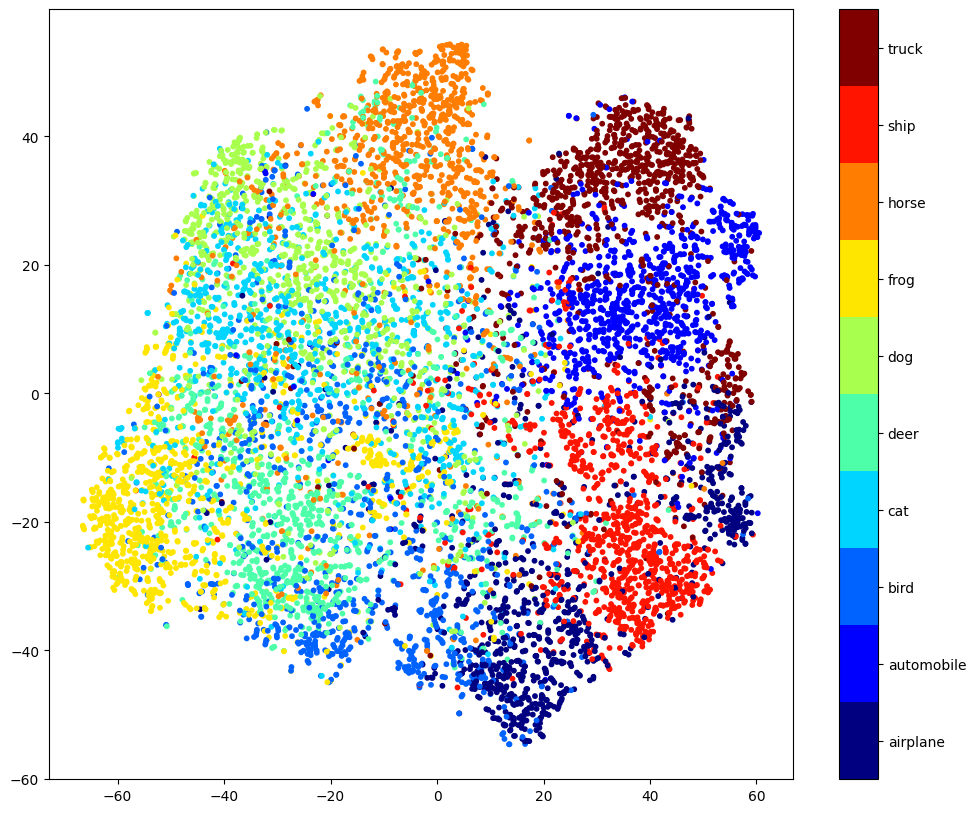

In [31]:
cifar_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
# 0: airplane
# 1: automobile
# 2: bird
# 3: cat
# 4: deer
# 5: dog
# 6: frog
# 7: horse
# 8: ship
# 9: truck
labels = [y for _, y in testimages]

fig = plt.figure(figsize=(12, 10))
plt.scatter(feats_2d[:,0], feats_2d[:,1], c=labels, cmap=plt.cm.get_cmap("jet", 10), s=10)
plt.clim(-0.5, 9.5)
cbar = plt.colorbar(ticks=range(10))
cbar.ax.set_yticklabels(cifar_labels);
fig.show()

**Exercise 7:** What categories seem to be easier for our model? Which ones are confusing?


## Optional: Synthesizing images to maximize activations


Here we will synthesize an image that maximizes the activation of a particular filter. We will be able to know what kind of pattern significantly activates a particular feature map.

**Resources**

Erhan, Dumitru & Bengio, Y. & Courville, Aaron & Vincent, Pascal. (2009). Visualizing Higher-Layer Features of a Deep Network. Technical Report, Univeristé de Montréal.

J. Yosinski, J. Clune, A. Nguyen, T. Fuchs, and H. Lipson, Understanding neural networks through deep visualization, ICML DL workshop, 2015

https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030


In [32]:
# Enable gradients computation
_ = torch.set_grad_enabled(True)

A hook class that will help us to obtain the activation map of a certain layer.

In [33]:
class SaveFeatures():
    def __init__(self,
                 module: torch.nn.modules.conv.Conv2d) -> None:
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self,
                module: torch.nn.modules.conv.Conv2d,
                input: torch.Tensor,
                output: torch.Tensor) -> None:
        self.features = output

    def close(self) -> None:
        self.hook.remove()

Helper function to visualize properly the results

In [34]:
def display_image(img: np.ndarray,
                  title: str='',
                  size: bool=False) -> None:
  h = plt.imshow(img, interpolation='none')
  if size:
    dpi = h.figure.get_dpi()/size
    h.figure.set_figwidth(img.shape[1] / dpi)
    h.figure.set_figheight(img.shape[0] / dpi)
    h.figure.canvas.resize(img.shape[1] + 1, img.shape[0] + 1)
    h.axes.set_position([0, 0, 1, 1])
    h.axes.set_xlim(-1, img.shape[1])
    h.axes.set_ylim(img.shape[0], -1)
  plt.grid(False)
  plt.title(title)
  plt.show()

Model definition. In this lab we are going to use VGG16

In [35]:
weights = torchvision.models.VGG16_BN_Weights.DEFAULT
model = torchvision.models.vgg16_bn(weights=weights).features.cuda().eval()
print(model)
for p in model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:10<00:00, 54.0MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

Now we are going to define the initial image, to do that we are going to define an image of size sz x sz with a uniform distribution. Moreover, we are going to use mean and std from imagenet to optimize our image.

In [45]:
img = torch.empty(3, hparams['sz'], hparams['sz'], device=device).uniform_(150, 180).round()/255

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

reverse_normalize = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                         std = [1/0.229, 1/0.224, 1/0.225])

Time to optimize our image!!

<ipython-input-34-c7d0529af02b>:9: MatplotlibDeprecationWarning: The resize method was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use FigureManagerBase.resize instead.
  h.figure.canvas.resize(img.shape[1] + 1, img.shape[0] + 1)


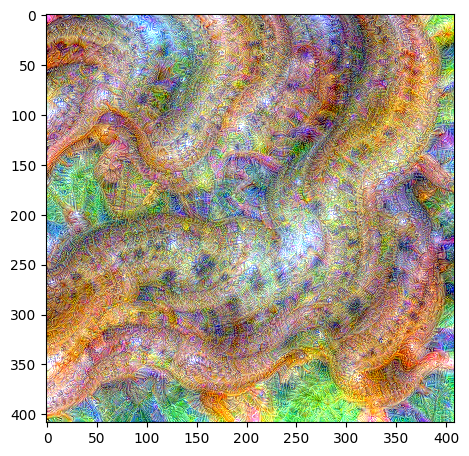

In [51]:
sz = hparams['sz']
hparams['filter'] = 115
for _ in range(hparams['upscaling_steps']):
  img = normalize(img)
  img = img.unsqueeze(0)
  img.requires_grad = True
  optimizer = torch.optim.Adam([img], lr=0.1, weight_decay=1e-6)
  activations = SaveFeatures(list(model.children())[hparams['layer']])

  for n in range(hparams['opt_steps']):
      optimizer.zero_grad()
      out=model(img)
      activation = activations.features[0, hparams['filter']]
      loss = -torch.mean(activation)
      loss.backward()
      optimizer.step()

  img = img.squeeze(0)
  img = reverse_normalize(img)
  img = img.cpu().detach().numpy()
  img = img.transpose(1, 2, 0)
  out = img.copy()
  activations.close()
  sz = int(hparams['upscaling_factor'] * sz)
  img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)
  if hparams['blur'] is not None: img = cv2.blur(img, (hparams['blur'], hparams['blur']))
  img = torch.from_numpy(img.transpose(2,0,1)).cuda()
display_image(np.clip(out, 0, 1), size=1)

It seems that filter 265 from layer 40th has learned to identify some chain patterns. Is it possible to test this hypothesis? The answer is... YES!!! We can simply apply the network to a picture and plot the average activations of the feature maps in the 40th layer. Let's do it!

--2023-11-23 13:46:02--  https://upload.wikimedia.org/wikipedia/commons/b/bb/Broad_chain_closeup.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100730 (98K) [image/jpeg]
Saving to: ‘Broad_chain_closeup.jpg’

Broad_chain_closeup 100%[===================>]  98.37K  --.-KB/s    in 0.05s   

2023-11-23 13:46:02 (1.82 MB/s) - ‘Broad_chain_closeup.jpg’ saved [100730/100730]



<ipython-input-34-c7d0529af02b>:9: MatplotlibDeprecationWarning: The resize method was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use FigureManagerBase.resize instead.
  h.figure.canvas.resize(img.shape[1] + 1, img.shape[0] + 1)


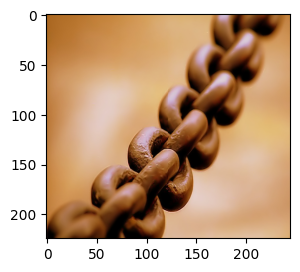

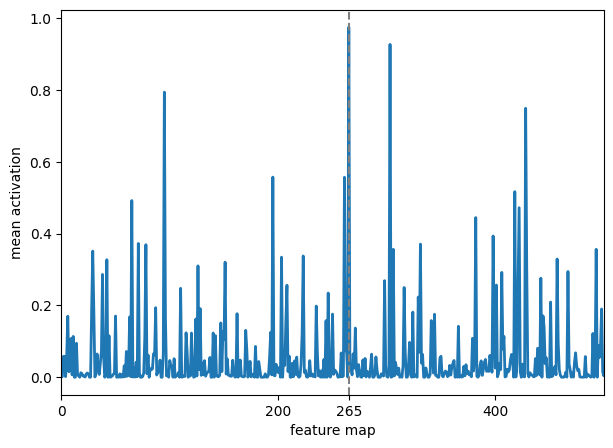

In [38]:
if not os.path.exists('Broad_chain_closeup.jpg'):
  !wget "https://upload.wikimedia.org/wikipedia/commons/b/bb/Broad_chain_closeup.jpg"

#Instead of using the Convolutional layer, we are using the activation layer.
#The only reason for choosing layer 42 instead of 40 is that otherwise,
#the plot would show a large amount of negative noise that made it hard to see
#the positive spikes we are interested in.
layer = hparams['layer'] + 2 # 42
total_filters_in_layer = 512


img = skimage.io.imread("Broad_chain_closeup.jpg")
img = skimage.transform.resize(img, (224, 244))
display_image(img, size=1)
img = np.array(img).transpose(2,0,1).astype(np.double)
img_t = torch.tensor(img)
img_t = img_t.type(torch.FloatTensor)
img_t = normalize(img_t)

activations = SaveFeatures(list(model.children())[layer])
out=model(img_t.unsqueeze(0).cuda())

mean_act = [activations.features[0,i].mean().item() for i in range(total_filters_in_layer)]

plt.figure(figsize=(7,5))
act = plt.plot(mean_act, linewidth=2.)
extraticks=[hparams['filter']]
ax = act[0].axes
ax.set_xlim(0,500)
plt.axvline(x=hparams['filter'], color='grey', linestyle='--')
ax.set_xlabel("feature map")
ax.set_ylabel("mean activation")
ax.set_xticks([0,200,400] + extraticks)
plt.show()

We can see a strong spike at feature map 265th. That shows that an image of a chain has a strong activation on the selected feature map.